# Tiny MNIST Classification

In the POC_Classification notebook we show how we can achieve beyond 99% accuracy on the MNIST test set using our POC algorithm.

In this notebook, we build on top of those results, and show that the POC algorithm can perform handwritten digit classification with ultra-small training sets. For this purpose, we use reduced versions of the MNIST datasetd, denoted as **RMNIST/N**, which containe N examples of each of the MNIST classes, e.g., RMNIST/1 contains only one image for each class (10 images in total).

In [1]:
import os
import sys
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import torch
import kymatio as km
from  matplotlib import pyplot as plt

sys.path.append("..")

from lib.data.data_loading import ClassificationDataset
from lib.data.reduced_dataset import ReducedDataset
from lib.data.data_processing import convert_images_to_scat
from lib.utils.visualizations import display_subset_data, visualize_accuracy_landscape
from lib.projections.projection_orthogonal_complement import get_features_all_classes, \
    extract_cluster_features, projections_classifier, optimize_dimensionality
from CONFIG import CONFIG

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
# macros and global variables
N_IMGS = 100  # number of images fgor each class in the dataset
MAX_DIMS = 300  # maximum nubmer of directions to consider
STEP = 20  # step for considering distances (e.g., [5, 10, 15, ...])
NUM_EXPS = 5  # number of experiments to average

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
ROOT_PATH = os.path.dirname(os.path.dirname(os.getcwd()))
DATA_PATH = os.path.join(ROOT_PATH, CONFIG["paths"]["data_path"])

# 1. Loading the Data

In [4]:
# loading all mnist data
mnist_dataset = ClassificationDataset(data_path=DATA_PATH, dataset_name="mnist", valid_size=0.25) 
train_imgs, train_labels = mnist_dataset.train_data, mnist_dataset.train_labels
valid_imgs, valid_labels = mnist_dataset.valid_data, mnist_dataset.valid_labels
test_imgs, test_labels = mnist_dataset.test_data, mnist_dataset.test_labels

In [5]:
# defining the scattering network
J = 3  # spatial field of the kernel is 2**J 
L = 6  # number of angles in the kernel
shape = (32,32)  # shape of the input images
max_order = 2 # depth of the network
scattering_layer = km.Scattering2D(J=J, shape=shape, max_order=max_order, L=L)
if DEVICE.type == 'cuda':
    scattering_layer = scattering_layer.cuda()

In [6]:
# computing the scattering transform of validation and test images
print("Processing valid-set images...")
valid_scat_features = convert_images_to_scat(images=valid_imgs, scattering=scattering_layer, device=DEVICE, equalize=True)
print("Processing test-set images...")
test_scat_features = convert_images_to_scat(images=test_imgs, scattering=scattering_layer, device=DEVICE, equalize=True)

Processing valid-set images...
Processing test-set images...


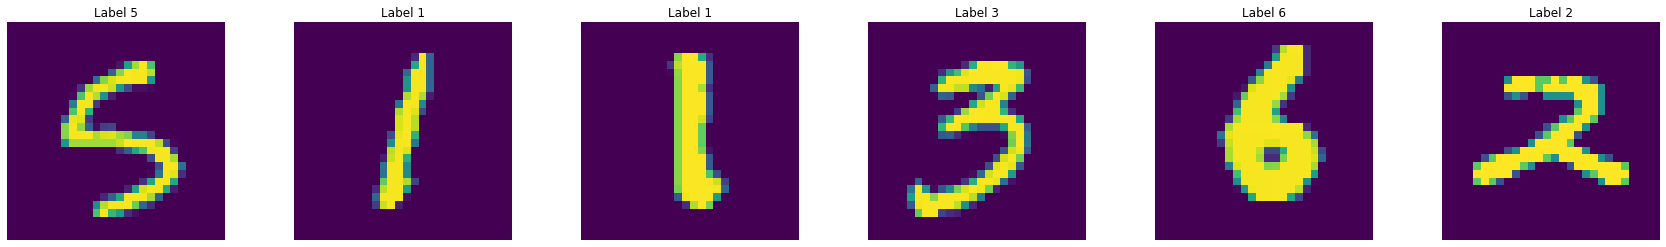

In [7]:
display_subset_data(imgs=train_imgs, labels=train_labels)

# 2. Experiments with N Images per Class

In [8]:
reduced_dataset = ReducedDataset(data=train_imgs, labels=train_labels, n_imgs=100)

## 2.1 Scattering Transform and Feature Extraction

In [9]:
train_imgs = reduced_dataset.data
train_labels = reduced_dataset.labels
train_scat_features = convert_images_to_scat(images=train_imgs, scattering=scattering_layer, device=DEVICE, equalize=True)


In [10]:
cluster_ids = np.arange(10).tolist()

# extracting features for the data in the pixel domain
img_classwise_data, img_prototypes,\
    img_eigenvectors = get_features_all_classes(data=train_imgs, labels=train_labels, verbose=1,
                                                cluster_ids=cluster_ids, standarize=False)

# extracting features for the scattering in the pixel domain
scat_classwise_data, scat_prototypes,\
    scat_eigenvectors = get_features_all_classes(data=train_scat_features, labels=train_labels, verbose=1,
                                                 cluster_ids=cluster_ids, standarize=False)

100%|██████████| 10/10 [00:44<00:00,  4.49s/it]


## 2.2 Parameter Optimization


In [11]:
direction_candidates = np.arange(0, MAX_DIMS, STEP)

### 2.2.1 Optimizing for Raw Images

In [12]:
opt_dims_img, max_acc_img,\
    accuracies_img = optimize_dimensionality(data=valid_imgs, labels=valid_labels,
                                             dims=direction_candidates, 
                                             prototypes=img_prototypes,
                                             eigenvectors=img_eigenvectors,
                                             verbose=1)

100%|██████████| 15/15 [00:37<00:00,  2.50s/it]

Maximum accuracy was 91.83. It was found removing 40 directions.


In [13]:
min_dims = max(0, opt_dims_img - 10)
max_dims = min(MAX_DIMS, opt_dims_img + 11)
fine_direction_candidates = np.arange(min_dims, max_dims)

fine_opt_dims_img, fine_max_acc_img,\
    fine_accuracies_img = optimize_dimensionality(data=valid_imgs, labels=valid_labels,
                                                  dims=fine_direction_candidates, 
                                                  prototypes=img_prototypes,
                                                  eigenvectors=img_eigenvectors, verbose=1)

100%|██████████| 21/21 [00:55<00:00,  2.63s/it]

Maximum accuracy was 91.88. It was found removing 41 directions.


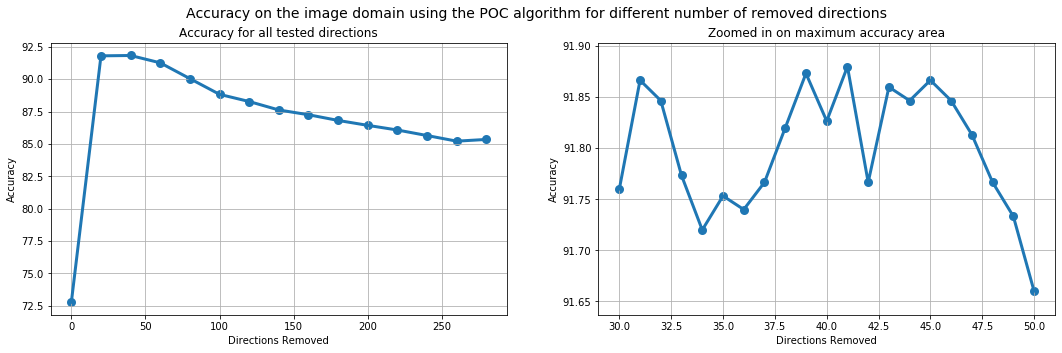

In [14]:
fig, ax = plt.subplots(1, 2)
fig.set_size_inches(18,5)
fig.suptitle("Accuracy on the image domain using the POC algorithm for different number of removed directions", fontsize=14)
visualize_accuracy_landscape(xaxis=direction_candidates, accuracy=accuracies_img, 
                             ax=ax[0], xlabel="Directions Removed", ylabel="Accuracy",
                             title="Accuracy for all tested directions", grid=True)
visualize_accuracy_landscape(xaxis=fine_direction_candidates, accuracy=fine_accuracies_img, 
                             ax=ax[1], xlabel="Directions Removed", ylabel="Accuracy",
                             title="Zoomed in on maximum accuracy area", grid=True)

### 2.2.2 Optimizing for the Scattering Domain

In [15]:
direction_candidates = np.arange(0, MAX_DIMS, STEP)

In [16]:
opt_dims_scat, max_acc_scat,\
    accuracies_scat = optimize_dimensionality(data=valid_scat_features, labels=valid_labels,
                                             dims=direction_candidates, 
                                             prototypes=scat_prototypes,
                                             eigenvectors=scat_eigenvectors,
                                             verbose=1)

100%|██████████| 15/15 [02:27<00:00,  9.82s/it]

Maximum accuracy was 97.55. It was found removing 80 directions.


In [ ]:
min_dims = max(0, opt_dims_scat - 10)
max_dims = min(MAX_DIMS, opt_dims_scat + 11)
fine_direction_candidates = np.arange(min_dims, max_dims)

fine_opt_dims_scat, fine_max_acc_scat,\
    fine_accuracies_scat = optimize_dimensionality(data=valid_scat_features, labels=valid_labels,
                                                   dims=fine_direction_candidates, 
                                                   prototypes=scat_prototypes,
                                                   eigenvectors=scat_eigenvectors,
                                                   verbose=1)

In [ ]:
fig, ax = plt.subplots(1, 2)
fig.set_size_inches(18,5)
fig.suptitle("Accuracy on the scattering domain using the POC algorithm for different number of removed directions", fontsize=14)
visualize_accuracy_landscape(xaxis=direction_candidates, accuracy=accuracies_scat, 
                             ax=ax[0], xlabel="Directions Removed", ylabel="Accuracy",
                             title="Accuracy for all tested directions", grid=True)
visualize_accuracy_landscape(xaxis=fine_direction_candidates, accuracy=fine_accuracies_scat, 
                             ax=ax[1], xlabel="Directions Removed", ylabel="Accuracy",
                             title="Zoomed in on maximum accuracy area", grid=True)

## 2.3 Test Set Evaluation

In [ ]:
pred_test_labels_img, _ = projections_classifier(points=test_imgs,
                                                 prototypes=img_prototypes,
                                                 eigenvectors=img_eigenvectors,
                                                 n_directions=fine_opt_dims_img)

n_correct_labels_img = len(np.where(pred_test_labels_img == test_labels.numpy())[0])
test_set_acc_img = 100 * n_correct_labels_img / len(test_labels)

In [ ]:
pred_test_labels_scat, _ = projections_classifier(points=test_scat_features,
                                                  prototypes=scat_prototypes,
                                                  eigenvectors=scat_eigenvectors,
                                                  n_directions=fine_opt_dims_scat)

n_correct_labels_scat = len(np.where(pred_test_labels_scat == test_labels.numpy())[0])
test_set_acc_scat = 100 * n_correct_labels_scat / len(test_labels)

In [ ]:
print(f"Test set accuracy results:")
print(f"    Img Domain:  {round(test_set_acc_img, 3)}%")
print(f"    Scat Domain: {round(test_set_acc_scat, 3)}%")

<div class=alert style="background-color:#F5F5F5; border-color:#C8C8C8">
   This notebook was created by <b>Angel Villar-Corrales</b>
</div> 